In [229]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [230]:
df = pd.read_csv('zad4_Stroke.csv', sep=';', decimal=',')
display(df)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1.0,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1.0,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0.0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,NaN,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0.0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
395,Female,58.0,0,0.0,Yes,NaN,Rural,69.12,28.3,Unknown,0
396,Female,79.0,0,0.0,No,Private,Urban,253.86,28.8,formerly smoked,0
397,Female,46.0,0,0.0,Yes,Govt_job,Urban,NaN,27.8,never smoked,0
398,Male,13.0,0,0.0,No,children,Urban,NaN,24.3,Unknown,0


In [231]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease        float64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [232]:
df['heart_disease'].fillna(df['heart_disease'].interpolate(), inplace=True)
df['avg_glucose_level'].fillna(df['avg_glucose_level'].interpolate(), inplace=True)
df['bmi'].fillna(df['bmi'].interpolate(), inplace=True)

In [233]:
df['stroke'].value_counts()

1    200
0    200
Name: stroke, dtype: int64

In [234]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_columns = [col for col in df.columns if col not in categorical_columns + ['stroke']]
x_numeric = df[numerical_columns]
x_categorical = df[categorical_columns]

encoder = LabelEncoder()
x_categorical_encoded = x_categorical.apply(encoder.fit_transform)

x = pd.concat([x_numeric, x_categorical_encoded], axis=1)
df.drop(['stroke'], axis=1)
y = df['stroke']


In [235]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [236]:
n_estimators_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

results = []

for n_estimators in n_estimators_values:
    base_model = DecisionTreeClassifier(max_depth=3)
    model = AdaBoostClassifier(base_model, n_estimators=n_estimators)
    
    scores = cross_val_score(model, x, y, cv=5)
    
    results.append((n_estimators, scores.mean()))

best_n_estimators, _ = max(results, key=lambda x: x[1])

print(f"Najlepsza liczba estymatorów: {best_n_estimators}")


Najlepsza liczba estymatorów: 70


In [237]:
for learning_rate in [0.01, 0.1, 0.5, 1.0]:
    model = AdaBoostClassifier(n_estimators=best_n_estimators, learning_rate=learning_rate)
    
    scores = cross_val_score(model, x, y, cv=5)

    accuracy = scores.mean()

    print(f"Dokładność modelu (learning_rate={learning_rate}) - walidacja krzyżowa: {accuracy}")

Dokładność modelu (learning_rate=0.01) - walidacja krzyżowa: 0.7725
Dokładność modelu (learning_rate=0.1) - walidacja krzyżowa: 0.7575000000000001
Dokładność modelu (learning_rate=0.5) - walidacja krzyżowa: 0.7399999999999999
Dokładność modelu (learning_rate=1.0) - walidacja krzyżowa: 0.7200000000000001


Wybór optymalnych parametrów

In [238]:
best_model = AdaBoostClassifier(n_estimators=best_n_estimators, learning_rate=0.1)
best_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=70)

Ocena ważności zmiennych

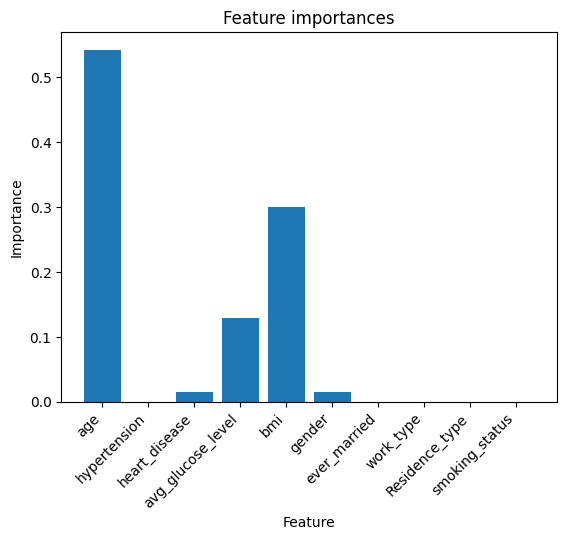

In [239]:
importance = best_model.feature_importances_
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), X_train.columns, rotation=45, ha="right")
plt.title("Feature importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

Ocena specyficzności

In [240]:
conf_matrix = confusion_matrix(y_test, best_model.predict(X_test))
true_negatives = conf_matrix[0, 0]
false_positives = conf_matrix[0, 1]
specificity = true_negatives / (true_negatives + false_positives)
print(f'Specificity: {specificity}')

Specificity: 0.5897435897435898


Raporty klasyfikacyjne

In [241]:
print("Zbiór uczący:")
report_train = classification_report(y_train, best_model.predict(X_train))
print(report_train)

print("Zbiór testowy:")
report_test = classification_report(y_test, best_model.predict(X_test))
print(report_test)

Zbiór uczący:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       161
           1       0.77      0.87      0.82       159

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320

Zbiór testowy:
              precision    recall  f1-score   support

           0       0.79      0.59      0.68        39
           1       0.69      0.85      0.76        41

    accuracy                           0.73        80
   macro avg       0.74      0.72      0.72        80
weighted avg       0.74      0.72      0.72        80

